In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

In [2]:
L_x, L_y, mu_x, mu_y = 1, 1, 0.5, 0.2
L_xy, mu_xy, mu_yx = 3, 2, 1

rho_a, rho_b, rho_c, rho_d = -np.inf, -np.inf, -np.inf, -np.inf

if (mu_x > 0) and (mu_y > 0):
    delta = (mu_y / mu_x)**.5
    sigma_x = (mu_x / (2 * L_x))**.5
    sigma_y = (mu_y / (2 * L_y))**.5
    rho_a = 4 + 4 * max((L_x / mu_x)**.5,
                    (L_y / mu_y)**.5,
                    L_xy / (mu_x * mu_y)**.5)
elif (mu_x > 0) and (mu_y == 0):
    delta = (mu_xy**2 / (2*mu_x*L_x))**.5
    sigma_x = (mu_x / (2 * L_x))**.5
    sigma_y = min(1, (mu_xy**2 / (4*L_x*L_y))**.5)
    rho_b = 4 + 8 * max((L_x * L_y)**.5 / mu_xy,
                    L_xy / mu_xy * (L_x / mu_x)**.5,
                    L_xy**2 / mu_xy**2)
elif (mu_x == 0) and (mu_y > 0):
    delta = (2*mu_y**2 * L_y / mu_yx**2)**.5
    sigma_x = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    sigma_y = (mu_y / (2 * L_y))**.5
    rho_c = 4 + 8 * max((L_x * L_y)**.5 / mu_yx,
                        L_xy / mu_yx *(L_y / mu_y)**.5,
                        L_xy**2 / mu_xy**2)
elif (mu_x == 0) and (mu_y == 0):
    delta = (mu_xy / mu_yx)*(L_y / L_x)**.5
    sigma_x = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    sigma_y = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    rho_d = 2 + 8 * max((L_x * L_y)**.5 * L_xy / (mu_xy * mu_yx),
                    L_xy**2 / mu_yx**2,
                    L_xy**2 / mu_xy**2)

theta = 1 - max(rho_a, rho_b, rho_c, rho_d)
eta_x = min(1 / (4 * (mu_x + L_x * sigma_x)), delta/(4*L_xy))
eta_y = min(1 / (4 * (mu_y + L_y * sigma_y)), 1/(4*L_xy * delta))
tau_x = (sigma_x**(-1) + 0.5)**(-1)
tau_y = (sigma_y**(-1) + 0.5)**(-1)
alpha_x = mu_x
alpha_y = mu_y
beta_x = min(1/(2*L_y), 1/(1*eta_x*L_xy**2))
beta_y = min(1/(2*L_x), 1/(1*eta_y*L_xy**2))

In [3]:
A = 0.5 + 0.1 * np.random.randn(5, 6)

In [4]:
import scipy.linalg as sla

# TODO: We need only lam_max, lam+_min and lam_min/ Faster way?
spectrum = sla.svd(A.T.dot(A))[1]
L_xy = spectrum.max()**.5
mu_yx = spectrum.min() 
mu_xy = sla.svd(A.dot(A.T))[1].min()

**Evaluation**

In [2]:
sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2240.52it/s]
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Cre

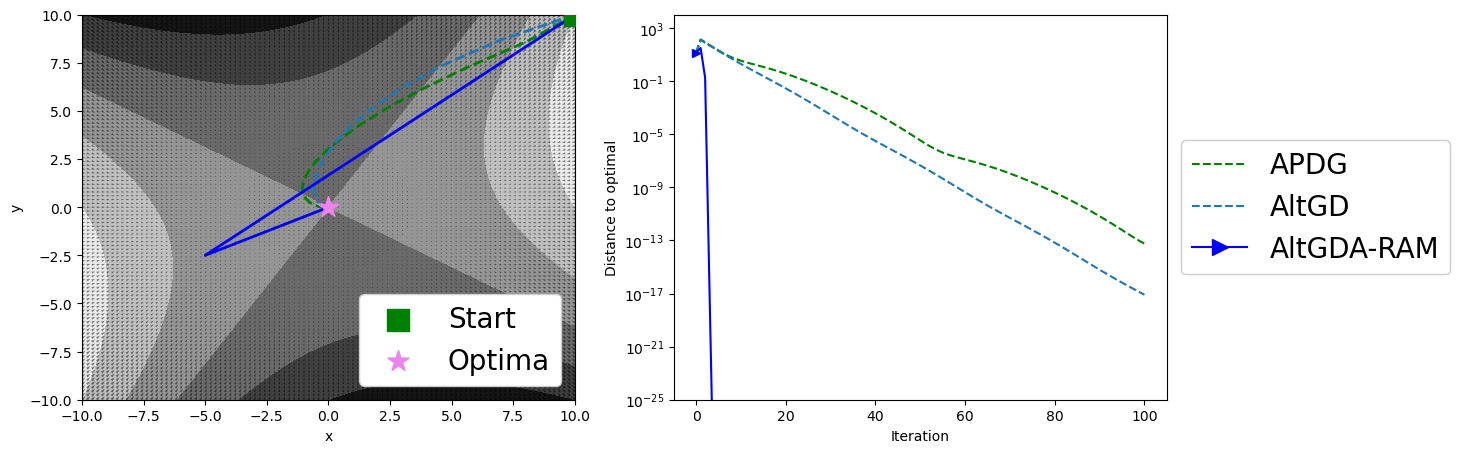

In [17]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

figname = 'APDG__opt.png'
FIG_DIR = os.path.join("..", "figures")
if not os.path.exists(FIG_DIR):
    os.mkdir(FIG_DIR)
    
k = 5
markevery= 10
x0, y0 = np.array([10.]),np.array([10.])
A = np.eye(1, 1)

problem = pr.func2(A=A)
xopt, yopt = problem.xopt, problem.yopt
params = {"apdg": None,
          'altgd': 0.1,
          'AA': 0.5
         }
xmin, xmax, xstep = (-10, 10, .2)
ymin, ymax, ystep = (-10, 10, .2)
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}
f = problem.f
g = problem.g

type2=True
iteration = 100
loss_f3, xpath_f3, ypath_f3 = ut.main(problem, iteration, x0.copy(), y0.copy(), params, k=k)

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = lambda x, y: f(x, y) - g(x, y) + x * A * y
z = z(x, y)
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(g, argnum=1)(x, y)
ut.plot(x, y, z, dz_dx, dz_dy, 
        loss_f3, xpath_f3, ypath_f3, iteration, k, 
        start=(x0, y0), solution=(xopt, yopt), 
        ranges={"x": (-10, 10, .2),
                "y": (-10, 10, .2)
               }, figname=figname,
        fig_dir=FIG_DIR, markevery=10)

## Ndim

In [20]:
problem_n = pr.GeneralSaddle(n=3, spd=True)
params = {'apdg': None,
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.random.randn(3, )
y0 = np.random.randn(3, )
type2=True
iteration = 100
k =  10
loss_f3, xpath_f3, ypath_f3 = ut.main(problem_n, iteration, x0.copy(), y0.copy(), params, k=k)

spd
bc zeros


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2220.14it/s]


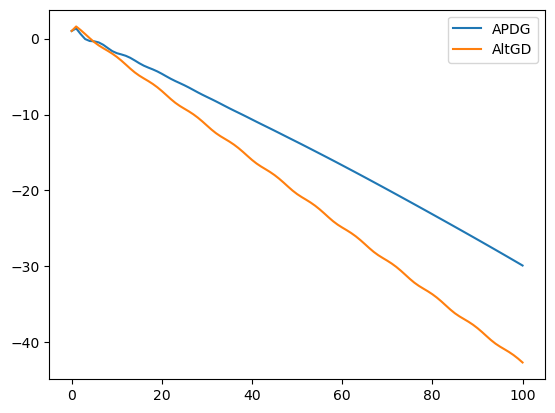

In [26]:
%matplotlib inline
import numpy as np
plt.plot(np.log(loss_f3[0]), label="APDG")
plt.plot(np.log(loss_f3[1]), label="AltGD")
plt.legend()

In [73]:
import autograd.numpy as np

class func3(pr.BaseSaddle):
    def __init__(self):
        super().__init__(np.zeros((1,1)))
        self.xopt, self.yopt = -100, 0. 
        self.xrange = [-5, 5, .1]
        self.yrange = [-5, 5, .1]
        self.f = lambda x, y: np.log(1 + np.exp(-x))
        self.g = lambda x, y:  y**2
        self.L_x = 0.25
        self.mu_x = 0
        
        self.L_y = 2
        self.mu_y = 2
        
        self.L_xy = 1
        self.mu_yx = 1
        self.mu_xy = 1
        self.A = np.eye(1)
        
        self.constraint=False   
        self.dfdx = grad(self.f)
        self.dfdy = 0  
        self.dgdx = 0
        self.dgdy = grad(self.g, 1)  
        self.d2fdxdx = grad(self.dfdx)
        self.d2fdydy = grad(self.dfdy, 1)
        self.d2fdxdy = grad(self.dfdx, 1)
        self.d2fdydx = grad(self.dfdy)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\autograd\numpy\numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 456.50it/s]


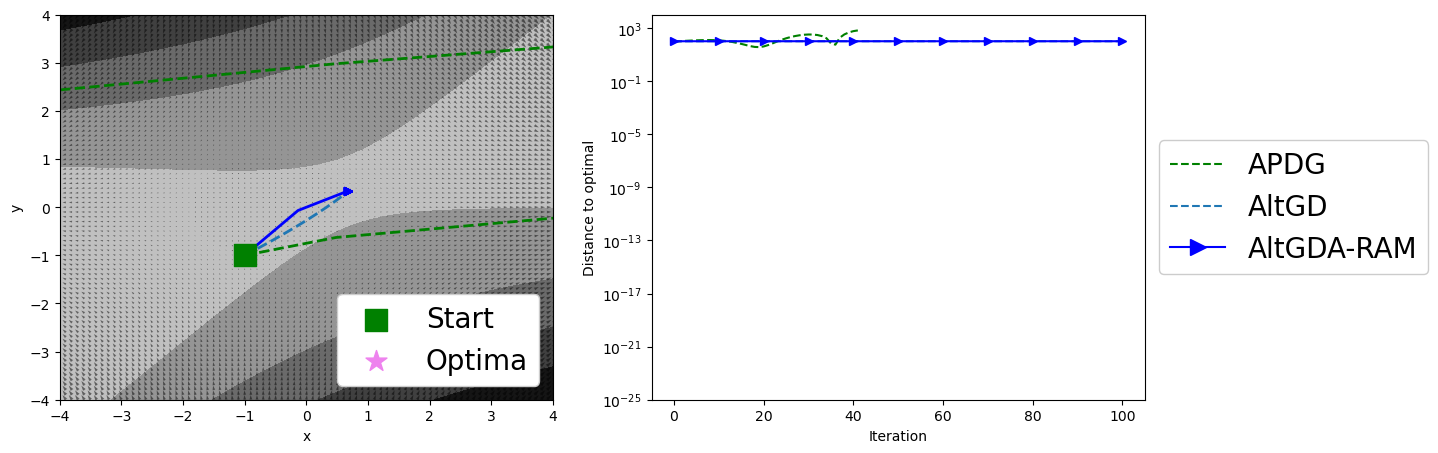

In [74]:
A = np.eye(1, 1)
problem_3 = func3()
x0, y0 = np.array([-1.]), np.array([-1.])
xopt, yopt = problem_3.xopt, problem_3.yopt
params = {"apdg": None,
          'altgd': 0.1,
          'AA': 0.5
         }
xmin, xmax, xstep = (-4, 4, .1)
ymin, ymax, ystep = (-4, 4, .1)
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}
f = problem_3.f
g = problem_3.g

type2=True
iteration = 100
loss_f3, xpath_f3, ypath_f3 = ut.main(problem_3, iteration, x0.copy(), y0.copy(), params, k=k)

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = lambda x, y: f(x, y) - g(x, y) + x * A * y
z = z(x, y)
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(g, argnum=1)(x, y)
ut.plot(x, y, z, dz_dx, dz_dy, 
        loss_f3, xpath_f3, ypath_f3, iteration, k, 
        start=(x0, y0), solution=(xopt, yopt), 
        ranges={"x": (-4, 4, .1),
                "y": (-4, 4, .1)
               }, figname=figname,
        fig_dir=FIG_DIR, markevery=10)

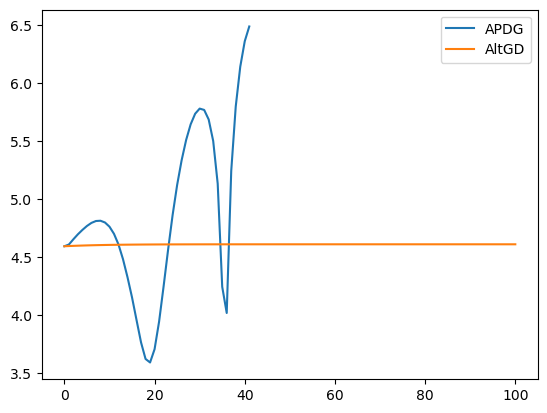

In [75]:
%matplotlib inline
import numpy as np
plt.plot(np.log(loss_f3[0]), label="APDG")
plt.plot(np.log(loss_f3[1]), label="AltGD")
plt.legend()